In [5]:
import numpy as np
import pandas as pd
import datetime
import glob
from pathlib import Path
from scipy import stats
import seaborn as sns
import json
%matplotlib inline

# Login

In [6]:
#Read in csv
login = pd.read_csv('../Dataset/login.csv', index_col='login')
#Convert Unix epoch to datetime
login['Reg_Datetime'] = pd.to_datetime(login['reg_date'],unit='s')
login.drop(columns='reg_date', inplace=True)

In [7]:
# Read the country mapping from the JSON file
with open("../country_mapping.json", "r") as json_file:
    country_mapping = json.load(json_file)

In [8]:
#Country mapping
login['country'] = login['country'].replace(country_mapping)

# Symbol

In [10]:
#Read in csv
symbol = pd.read_csv('../Dataset/symbol.csv', index_col='symbol')

# Reason

In [11]:
#Read in csv
reason = pd.read_csv('../Dataset/reason.csv', index_col='code')
#Group insignificant reasons under 'Other'
imp_reason = ['Client', 'Expert', 'Mobile']
reason['reason'] = reason['reason'].apply(lambda x: x if x in imp_reason else 'Other')

# Daily Chart

In [12]:
#Read in csvs
daily_charts = glob.glob("../Dataset/daily_chart/*.csv")
all_charts = pd.DataFrame()
for chart in daily_charts:
    name = Path(chart).stem
    csv = pd.read_csv(chart, index_col='date', parse_dates=True)
    all_charts[name] = csv['close']
#Create chart for conversion to USD
usd_columns = [col for col in all_charts.columns if col.startswith('USD')]
all_charts_USD = all_charts.copy()
all_charts_USD[usd_columns] = 1 / all_charts_USD[usd_columns]
all_charts_USD.columns = [col.replace('USD', '') for col in all_charts_USD.columns]
all_charts_USD['USD'] = float(1)

# Trades

In [13]:
#Read in csv
trades = pd.read_csv('../Dataset/trades.csv', index_col='ticket')
#Convert open and close from Unix Epoch to datetime
trades['Open_Datetime'] = pd.to_datetime(trades['open_time'],unit='s')
trades['Close_Datetime'] = pd.to_datetime(trades['close_time'],unit='s')
trades['Trade_Duration'] = trades['Close_Datetime'] - trades['Open_Datetime']
trades.drop(columns=['open_time', 'close_time'], inplace=True)
#Convert reason
trades['Reason'] = reason.loc[trades['reason'], 'reason'].values
trades.drop(columns='reason', inplace=True)
#Add symbol types
trades = trades.join(symbol['type'], on='symbol')

In [14]:
#Add account currency and trade date (open)
trades_USD = trades.join(login['account_currency'], on='login')
trades_USD['Trade_Date'] = pd.to_datetime(pd.to_datetime(trades_USD['Open_Datetime']).dt.date)
#Add relevant conversion rate
trades_USD = pd.merge(trades_USD, all_charts_USD.stack().rename('usd_rate'), how='left', left_on=['Trade_Date', 'account_currency'], right_index=True)
#Convert non-USD columns to USD
trades_conversions = ['commission', 'swaps', 'profit']
for column in trades_conversions:
    trades_USD[column] = trades_USD [column] * trades_USD['usd_rate']
trades_USD.drop(columns=['account_currency', 'Trade_Date', 'usd_rate'], inplace=True)

# Daily Report

In [15]:
#Read in csv
report = pd.read_csv('../Dataset/daily_report.csv')
#Convert record time to datetime
report['record_time'] = pd.to_datetime(report['record_time'])
#Add account currency
report_USD = report.join(login['account_currency'], on='login')
#Add relevant conversion rate
all_charts_USD_backfill = pd.merge(report_USD['record_time'], all_charts_USD.reset_index(), how='left', left_on='record_time', right_on='date').fillna(method='bfill').drop(columns='date').rename(columns={'record_time':'date'}).set_index('date')
all_charts_USD_backfill = all_charts_USD_backfill.groupby(level=0).first().stack()
report_USD = pd.merge(report_USD, all_charts_USD_backfill.rename('usd_rate'), how='left', left_on=['record_time', 'account_currency'], right_index=True)
#Convert non-USD columns to USD
report_conversions = ['net_deposit', 'balance', 'equity', 'credit', 'profit_closed', 'profit_floating', 'margin']
for column in report_conversions:
    report_USD[column] = report_USD [column] * report_USD['usd_rate']
report_USD.drop(columns=['account_currency', 'usd_rate'], inplace=True)

C:\Users\talha\AppData\Local\Temp\ipykernel_21320\1314935852.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_charts_USD_backfill = pd.merge(report_USD['record_time'], all_charts_USD.reset_index(), how='left', left_on='record_time', right_on='date').fillna(method='bfill').drop(columns='date').rename(columns={'record_time':'date'}).set_index('date')


# Merged Datasets (> 2023-01-01)

In [16]:
login_2023 = login[login['Reg_Datetime'] >= '2023-01-01']
login_2023.sort_values('Reg_Datetime')

,country,account_currency,Reg_Datetime
login,,,
88944135,France,EUR,2023-01-01 00:04:13
88944138,Singapore,USD,2023-01-01 04:15:15
88944152,Nigeria,USD,2023-01-01 14:52:14
88944153,Germany,EUR,2023-01-01 14:56:28
88944161,France,EUR,2023-01-01 18:42:26
...,...,...,...
524987,Malaysia,USD,2024-03-01 07:39:18
524988,Malaysia,USD,2024-03-01 07:40:03
524989,Malaysia,USD,2024-03-01 07:40:51


In [17]:
login_trades = pd.merge(login_2023, trades_USD.reset_index(), how='inner', on='login').set_index(['login'])
login_trades

,country,account_currency,Reg_Datetime,ticket,symbol,cmd,volume,open_price,close_price,tp,sl,commission,swaps,profit,volume_usd,Open_Datetime,Close_Datetime,Trade_Duration,Reason,type
login,,,,,,,,,,,,,,,,,,,,
524974,Switzerland,USD,2023-05-17 03:13:02,68288434,XAUUSD,1,0.07,2025.48000,2025.41000,2015.59,2025.31,0.00,0.0,0.49,28356.23,2024-01-29 08:00:00,2024-01-29 08:05:37,0 days 00:05:37,Expert,Metal
524974,Switzerland,USD,2023-05-17 03:13:02,60331067,XAUUSD,0,0.03,1976.19000,1976.66000,1986.11,1976.70,0.00,0.0,1.41,11858.55,2023-06-01 22:00:00,2023-06-01 22:05:38,0 days 00:05:38,Expert,Metal
524974,Switzerland,USD,2023-05-17 03:13:02,68303022,XAUUSD,1,0.07,2036.84000,2036.47000,1996.87,2036.42,0.00,0.0,2.59,28513.17,2024-01-29 16:00:00,2024-01-29 16:02:05,0 days 00:02:05,Expert,Metal
524974,Switzerland,USD,2023-05-17 03:13:02,68455282,XAUUSD,0,0.07,2054.51000,2054.89000,2064.35,2054.99,0.00,0.0,2.66,28765.80,2024-02-01 20:00:00,2024-02-01 20:01:07,0 days 00:01:07,Expert,Metal
524974,Switzerland,USD,2023-05-17 03:13:02,68358126,XAUUSD,0,0.07,2036.24000,2036.32000,2046.10,2036.32,0.00,0.0,0.56,28507.92,2024-01-30 22:00:00,2024-01-30 22:34:54,0 days 00:34:54,Expert,Metal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000055123,Canada,USD,2023-11-07 08:04:15,66572516,EURUSD,0,0.04,1.08538,1.08551,0.00,0.00,-0.28,0.0,0.52,8683.56,2023-11-17 06:26:00,2023-11-17 07:59:02,0 days 01:33:02,Expert,Forex
1000055123,Canada,USD,2023-11-07 08:04:15,66578119,GBPCAD,0,0.10,1.70418,1.70528,0.00,0.00,-0.70,0.0,8.01,46756.31,2023-11-17 11:30:00,2023-11-17 11:44:42,0 days 00:14:42,Expert,Forex
1000055123,Canada,USD,2023-11-07 08:04:15,66579582,EURUSD,1,0.14,1.08667,1.08579,0.00,0.00,-0.98,0.0,12.32,30414.44,2023-11-17 12:23:00,2023-11-17 14:21:59,0 days 01:58:59,Expert,Forex


In [18]:
login_report = pd.merge(login_2023, report_USD, how='inner', on='login').set_index(['login'])
login_report

,country,account_currency,Reg_Datetime,record_time,net_deposit,balance,equity,credit,profit_closed,profit_floating,margin
login,,,,,,,,,,,
524972,France,EUR,2023-05-09 05:26:44,2023-05-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0
524972,France,EUR,2023-05-09 05:26:44,2023-05-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0
524972,France,EUR,2023-05-09 05:26:44,2023-05-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0
524972,France,EUR,2023-05-09 05:26:44,2023-05-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0
524972,France,EUR,2023-05-09 05:26:44,2023-05-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1000059496,Canada,USD,2024-01-18 12:05:37,2024-02-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000059496,Canada,USD,2024-01-18 12:05:37,2024-02-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000059496,Canada,USD,2024-01-18 12:05:37,2024-02-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Trading Strategies

Trade activity

In [19]:
#Calculate time between:
# - first trade open and last trade close
# - registration date and first trade open
earliest_trades_opened = login_trades['Open_Datetime'].groupby(level=0).min()
latest_trades_closed = login_trades['Close_Datetime'].groupby(level=0).max()
login_activity = earliest_trades_opened.to_frame().join(latest_trades_closed, how='inner')
login_activity = login_activity.join(login['Reg_Datetime'], how='inner')
login_activity['Longevity'] = login_activity['Close_Datetime'] - login_activity['Open_Datetime']
login_activity['Reg_First_Gap'] = login_activity['Open_Datetime'] - login_activity['Reg_Datetime']
#Bin longevity for classification
bins = [-1, 30, 90, 180, 270, 360, float('inf')]
login_activity['Longevity_Bin'] = pd.cut(login_activity['Longevity'].dt.days, bins=bins, labels=False)
#Add total and average trades per day over trading period
login_activity['Total_Trades'] = login_trades.groupby('login').count()['ticket']
login_activity['Avg_Daily_Trades'] = login_activity['Total_Trades'] / login_activity['Reg_First_Gap'].dt.days
login_activity.drop(inplace=True, columns=['Open_Datetime', 'Close_Datetime', 'Reg_Datetime'])
login_activity

,Longevity,Reg_First_Gap,Longevity_Bin,Total_Trades,Avg_Daily_Trades
login,,,,,
524974,286 days 16:01:47,2 days 02:47:11,4,143,71.500000
524978,142 days 22:58:19,34 days 15:57:56,2,1392,40.941176
524979,107 days 15:38:33,9 days 10:46:45,2,2194,243.777778
524984,92 days 06:35:16,13 days 00:20:48,2,244,18.769231
760487,13 days 04:20:34,1 days 08:02:32,0,69,69.000000
...,...,...,...,...,...
88945036,267 days 08:12:40,37 days 06:42:43,3,3555,96.081081
88945038,253 days 08:21:26,12 days 17:19:41,3,1306,108.833333
1000054825,143 days 10:29:03,7 days 20:43:22,2,829,118.428571


Types of assets traded

In [20]:
#Add sum of each asset types traded and total trades.
trade_types = login_trades.groupby(['login', 'type']).count()['ticket'].unstack(fill_value=0)
trade_types = trade_types.join(login_trades['ticket'].groupby('login').count()).rename(columns={'ticket' : 'Total'})
#Add percentage of all trades made per asset.
asset_types = ['Commodity', 'Crypto', 'Forex', 'Index', 'Metal', 'Oil']
for type in asset_types:
    trade_types[type + '_%'] = trade_types[type] / trade_types['Total']
#Add types traded.
trade_types['Types_Traded'] = login_trades.groupby(['login', 'type']).count().groupby(['login']).count()['ticket']
trade_types

,Commodity,Crypto,Forex,Index,Metal,Oil,Total,Commodity_%,Crypto_%,Forex_%,Index_%,Metal_%,Oil_%,Types_Traded
login,,,,,,,,,,,,,,
524974,0,0,0,0,143,0,143,0.0,0.0,0.000000,0.000000,1.000000,0.0,1
524978,0,0,1045,1,346,0,1392,0.0,0.0,0.750718,0.000718,0.248563,0.0,3
524979,0,0,0,1759,435,0,2194,0.0,0.0,0.000000,0.801732,0.198268,0.0,2
524984,0,0,34,0,210,0,244,0.0,0.0,0.139344,0.000000,0.860656,0.0,2
760487,0,0,0,69,0,0,69,0.0,0.0,0.000000,1.000000,0.000000,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88945036,0,0,3555,0,0,0,3555,0.0,0.0,1.000000,0.000000,0.000000,0.0,1
88945038,0,0,1306,0,0,0,1306,0.0,0.0,1.000000,0.000000,0.000000,0.0,1
1000054825,0,0,134,626,69,0,829,0.0,0.0,0.161641,0.755127,0.083233,0.0,3


Volume traded

In [21]:
trade_volume = login_trades[['cmd', 'volume_usd', 'Reason', 'type']].copy()
#Separate amounts into bought and sold (based on notional values)
trade_volume['Buy_Volume'] = trade_volume['volume_usd'].where(trade_volume['cmd'] == 0)
trade_volume['Sell_Volume'] = trade_volume['volume_usd'].where(trade_volume['cmd'] == 1)
#Add sums for all volumes (Total, Bought, and Sold)
total_trade_volume = trade_volume.groupby('login').sum(numeric_only=True).drop(columns=['cmd'])
total_trade_volume['type'] = 'Total'
total_trade_volume = total_trade_volume.reset_index().set_index(['login', 'type']).unstack()
trade_volume = trade_volume.groupby(['login', 'type']).sum(numeric_only=True).drop(columns=['cmd']).unstack().join(total_trade_volume).stack().unstack(1, fill_value=0)
#Calculate % of trades compared to total volumes
volumes = ['volume_usd', 'Buy_Volume', 'Sell_Volume']
asset_types = ['Commodity', 'Crypto', 'Forex', 'Index', 'Metal', 'Oil']
trade_volume_perc = trade_volume.copy()
for vol in volumes:
    for type in asset_types:
        trade_volume_perc[(vol, type)] = trade_volume[(vol, type)]/trade_volume[(vol, 'Total')]
    trade_volume_perc[(vol, 'Total')] = trade_volume[(vol, 'Total')] / trade_volume[('volume_usd', 'Total')]
#Combine totals and %
trade_volume_combined = trade_volume_perc.join(trade_volume, lsuffix='_%')
trade_volume_combined#.droplevel(0, axis=1)

trade_volume_perc_1_level = trade_volume_combined.index.to_frame()
all_types = ['Commodity', 'Crypto', 'Forex', 'Index', 'Metal', 'Oil', 'Total']
for vol in volumes:
    for type in all_types:
        trade_volume_perc_1_level[type + '_' + vol] = trade_volume_perc[(vol, type)]
trade_volume_perc_1_level.drop(columns=['login'], inplace=True)
trade_volume_perc_1_level

,Commodity_volume_usd,Crypto_volume_usd,Forex_volume_usd,Index_volume_usd,Metal_volume_usd,Oil_volume_usd,Total_volume_usd,Commodity_Buy_Volume,Crypto_Buy_Volume,Forex_Buy_Volume,...,Metal_Buy_Volume,Oil_Buy_Volume,Total_Buy_Volume,Commodity_Sell_Volume,Crypto_Sell_Volume,Forex_Sell_Volume,Index_Sell_Volume,Metal_Sell_Volume,Oil_Sell_Volume,Total_Sell_Volume
login,,,,,,,,,,,,,,,,,,,,,
524974,0.0,0.0,0.000000,0.000000e+00,1.000000,0.0,1.0,0.0,0.0,0.000000,...,1.000000,0.0,0.470740,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.529260
524978,0.0,0.0,0.999642,7.690441e-07,0.000357,0.0,1.0,0.0,0.0,0.999370,...,0.000630,0.0,0.292656,0.0,0.0,0.999755,0.000001,0.000244,0.0,0.707344
524979,0.0,0.0,0.000000,8.465652e-01,0.153435,0.0,1.0,0.0,0.0,0.000000,...,0.133617,0.0,0.511717,0.0,0.0,0.000000,0.825796,0.174204,0.0,0.488283
524984,0.0,0.0,0.979426,0.000000e+00,0.020574,0.0,1.0,0.0,0.0,0.046053,...,0.953947,0.0,0.008913,0.0,0.0,0.987820,0.000000,0.012180,0.0,0.991087
760487,0.0,0.0,0.000000,1.000000e+00,0.000000,0.0,1.0,0.0,0.0,0.000000,...,0.000000,0.0,0.130265,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.869735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88945036,0.0,0.0,1.000000,0.000000e+00,0.000000,0.0,1.0,0.0,0.0,1.000000,...,0.000000,0.0,0.499153,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.500847
88945038,0.0,0.0,1.000000,0.000000e+00,0.000000,0.0,1.0,0.0,0.0,1.000000,...,0.000000,0.0,0.568717,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.431283
1000054825,0.0,0.0,0.999109,7.918859e-04,0.000099,0.0,1.0,0.0,0.0,0.999303,...,0.000160,0.0,0.406953,0.0,0.0,0.998977,0.000967,0.000057,0.0,0.593047


Trading methods

In [22]:
#Add sum of each trading method used and total trades.
trade_methods = login_trades.groupby(['login', 'Reason']).count()['ticket'].unstack(fill_value=0)
trade_methods = trade_methods.join(login_trades['ticket'].groupby('login').count()).rename(columns={'ticket' : 'Total'})
#Add percentage of all trades made per method.
reason_types = ['Client', 'Expert', 'Mobile', 'Other']
for type in reason_types:
    trade_methods[type + '_%'] = trade_methods[type] / trade_methods['Total']
#Add methods used to make trades.
trade_methods['Methods_Used'] = login_trades.groupby(['login', 'Reason']).count().groupby(['login']).count()['ticket']
trade_methods

,Client,Expert,Mobile,Other,Total,Client_%,Expert_%,Mobile_%,Other_%,Methods_Used
login,,,,,,,,,,
524974,0,143,0,0,143,0.000000,1.000000,0.000000,0.0,1
524978,0,1392,0,0,1392,0.000000,1.000000,0.000000,0.0,1
524979,0,0,2194,0,2194,0.000000,0.000000,1.000000,0.0,1
524984,0,244,0,0,244,0.000000,1.000000,0.000000,0.0,1
760487,13,56,0,0,69,0.188406,0.811594,0.000000,0.0,2
...,...,...,...,...,...,...,...,...,...,...
88945036,0,3554,1,0,3555,0.000000,0.999719,0.000281,0.0,2
88945038,0,1306,0,0,1306,0.000000,1.000000,0.000000,0.0,1
1000054825,24,0,805,0,829,0.028951,0.000000,0.971049,0.0,2


Account activity

In [23]:
account_change = login_report.reset_index().set_index(['login', 'record_time']).sort_index(axis=0, level=['login', 'record_time']).drop(columns=['country', 'account_currency', 'Reg_Datetime'])
#Add change in values over time
account_columns = ['net_deposit', 'balance', 'equity', 'credit', 'profit_closed', 'profit_floating', 'margin']
for column in account_columns:
    account_change[column + '_change'] = account_change.groupby('login')[column].diff().fillna(value=0)
#Break changes into positive and negative
account_change_columns = ['net_deposit_change', 'balance_change', 'equity_change', 'credit_change', 'profit_closed_change', 'profit_floating_change', 'margin_change']
for column in account_change_columns:
    account_change[column + '+'] = account_change[column].where(account_change[column] >= 0).fillna(value=0)
    account_change[column + '-'] = account_change[column].where(account_change[column] <= 0).fillna(value=0)
account_change

net_deposit  balance  equity  credit  profit_closed  \
login      record_time                                                        
524972     2023-05-09           0.0      0.0     0.0     0.0            0.0   
           2023-05-10           0.0      0.0     0.0     0.0            0.0   
           2023-05-11           0.0      0.0     0.0     0.0            0.0   
           2023-05-12           0.0      0.0     0.0     0.0            0.0   
           2023-05-13           0.0      0.0     0.0     0.0            0.0   
...                             ...      ...     ...     ...            ...   
1000059496 2024-02-24           0.0      0.0     0.0     0.0            0.0   
           2024-02-25           0.0      0.0     0.0     0.0            0.0   
           2024-02-26           0.0      0.0     0.0     0.0            0.0   
           2024-02-27           0.0      0.0     0.0     0.0            0.0   
           2024-02-29           0.0      0.0     0.0     0.0            0.0   

                        profit_floating  margin  net_deposit_change  \
login      record_time                                                
524972     2023-05-09               0.0     0.0                 0.0   
           2023-05-10               0.0     0.0                 0.0   
           2023-05-11               0.0     0.0                 0.0   
           2023-05-12               0.0     0.0                 0.0   
           2023-05-13               0.0     0.0                 0.0   
...                                 ...     ...                 ...   
1000059496 2024-02-24               0.0     0.0                 0.0   
           2024-02-25               0.0     0.0                 0.0   
           2024-02-26               0.0     0.0                 0.0   
           2024-02-27               0.0     0.0                 0.0   
           2024-02-29               0.0     0.0                 0.0   

                        balance_change  equity_change  ...  equity_change+  \
login      record_time                                 ...                   
524972     2023-05-09              0.0            0.0  ...             0.0   
           2023-05-10              0.0            0.0  ...             0.0   
           2023-05-11              0.0            0.0  ...             0.0   
           2023-05-12              0.0            0.0  ...             0.0   
           2023-05-13              0.0            0.0  ...             0.0   
...                                ...            ...  ...             ...   
1000059496 2024-02-24              0.0            0.0  ...             0.0   
           2024-02-25              0.0            0.0  ...             0.0   
           2024-02-26              0.0            0.0  ...             0.0   
           2024-02-27              0.0            0.0  ...             0.0   
           2024-02-29              0.0            0.0  ...             0.0   

                        equity_change-  credit_change+  credit_change-  \
login      record_time                                                   
524972     2023-05-09              0.0             0.0             0.0   
           2023-05-10              0.0             0.0             0.0   
           2023-05-11              0.0             0.0             0.0   
           2023-05-12              0.0             0.0             0.0   
           2023-05-13              0.0             0.0             0.0   
...                                ...             ...             ...   
1000059496 2024-02-24              0.0             0.0             0.0   
           2024-02-25              0.0             0.0             0.0   
           2024-02-26              0.0             0.0             0.0   
           2024-02-27              0.0             0.0             0.0   
           2024-02-29              0.0             0.0             0.0   

                        profit_closed_change+  profit_closed_change-  \
login      record_time

In [24]:
account_activity = account_change.groupby('login').count().rename(columns={'balance' : 'Reports'})['Reports'].to_frame()
#Define get capital letter (for ease of viewing)
def gcl(input_string):
    return ''.join(letter for letter in input_string if letter.isupper())
#Add average values
average_account_columns = ['net_deposit', 'balance', 'equity', 'credit', 'profit_closed', 'profit_floating', 'margin', 'net_deposit_change', 'balance_change', 'equity_change', 'credit_change', 'profit_closed_change', 'profit_floating_change', 'margin_change']
for column in average_account_columns:
    account_activity['Avg_' + gcl(column.title())] = account_change[column].groupby('login').mean()
#Add summed values
sum_account_columns = ['net_deposit_change', 'balance_change', 'equity_change', 'credit_change', 'profit_closed_change', 'profit_floating_change', 'margin_change']
sum_modifiers = ['', '+', '-']
for column in sum_account_columns:
    for mod in sum_modifiers:
        account_activity[gcl(column.title()) + mod] = account_change[column + mod].groupby('login').sum()
#Add encoding for whether a client was given any credit
account_activity['Given_Credit'] = np.sign(account_change['credit'].groupby('login').max())
account_activity.drop(inplace=True, columns='Reports')
account_activity

,Avg_ND,Avg_B,Avg_E,Avg_C,Avg_PC,Avg_PF,Avg_M,Avg_NDC,Avg_BC,Avg_EC,...,PCC,PCC+,PCC-,PFC,PFC+,PFC-,MC,MC+,MC-,Given_Credit
login,,,,,,,,,,,,,,,,,,,,,
524972,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0
524974,0.704225,350.811056,350.400563,0.0,1.107570,-0.410493,1.378556,-7.042254e-01,1.107570,1.107570,...,2.100000e+00,221.830000,-219.730000,0.000000e+00,72.080000,-72.080000,0.000000e+00,314.510000,-314.510000,0.0
524976,-9.650357,2957.842855,2956.189076,0.0,9.530732,-1.653779,3.594011,-1.766009e-14,0.000000,0.000000,...,0.000000e+00,1629.828365,-1629.828365,0.000000e+00,331.524887,-331.524887,0.000000e+00,631.267111,-631.267111,0.0
524978,-194.736577,52906.832009,51551.422923,0.0,161.156849,-1355.409087,878.947941,0.000000e+00,0.000000,0.000000,...,-1.932676e-12,185085.815880,-185085.815880,-2.273737e-12,129734.241555,-129734.241555,-2.273737e-12,71385.716172,-71385.716172,0.0
524979,6.950570,513.283650,205.501445,0.0,-6.950456,-307.782205,49.642015,0.000000e+00,0.000114,0.000114,...,5.684342e-14,3195.510000,-3195.510000,0.000000e+00,2811.670000,-2811.670000,1.421085e-14,1281.210000,-1281.210000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000055123,0.000000,36671.151727,36257.755091,0.0,-22.536364,-413.396636,116.599909,0.000000e+00,341.100000,331.886909,...,-1.221800e+02,11579.210000,-11701.390000,-1.013440e+03,11964.990000,-12978.430000,8.189200e+02,5264.560000,-4445.640000,0.0
1000055441,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0
1000055515,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0


Trading gaps

In [25]:
#Add durations of gaps between trades (based on time between when a trade is opened) (could have used for loop)
trading_gaps = login_trades['Open_Datetime'].sort_values(axis=0).groupby('login').diff().fillna(value=pd.Timedelta('0')).to_frame().rename(columns={'Open_Datetime' : 'Trade_Gap'})
trading_gaps['1d_Gaps'] = trading_gaps['Trade_Gap'].where(trading_gaps['Trade_Gap'] > pd.Timedelta('1 days'))
trading_gaps['3d_Gaps'] = trading_gaps['Trade_Gap'].where(trading_gaps['Trade_Gap'] > pd.Timedelta('3 days'))
trading_gaps['1wk_Gaps'] = trading_gaps['Trade_Gap'].where(trading_gaps['Trade_Gap'] > pd.Timedelta('7 days'))
trading_gaps['2wk_Gaps'] = trading_gaps['Trade_Gap'].where(trading_gaps['Trade_Gap'] > pd.Timedelta('14 days'))
trading_gaps['1m_Gaps'] = trading_gaps['Trade_Gap'].where(trading_gaps['Trade_Gap'] > pd.Timedelta('30 days'))
trading_gaps['3m_Gaps'] = trading_gaps['Trade_Gap'].where(trading_gaps['Trade_Gap'] > pd.Timedelta('90 days'))
trading_gaps['6m_Gaps'] = trading_gaps['Trade_Gap'].where(trading_gaps['Trade_Gap'] > pd.Timedelta('180 days'))
#Add average gaps between trades
trading_periods = trading_gaps['Trade_Gap'].groupby('login').mean().to_frame()
#Count gaps between trades
trading_gap_columns = ['1d_Gaps', '3d_Gaps', '1wk_Gaps', '2wk_Gaps', '1m_Gaps', '3m_Gaps', '6m_Gaps']
for column in trading_gap_columns:
    trading_periods[column] = trading_gaps[column].groupby('login').count()
trading_periods

,Trade_Gap,1d_Gaps,3d_Gaps,1wk_Gaps,2wk_Gaps,1m_Gaps,3m_Gaps,6m_Gaps
login,,,,,,,,
524974,2 days 00:06:42.706293706,63,24,2,2,2,0,0
524978,0 days 02:27:50.841235632,22,6,1,0,0,0,0
524979,0 days 01:07:44.143573381,17,5,1,0,0,0,0
524984,0 days 09:04:06.823770491,8,1,1,1,1,0,0
760487,0 days 04:34:19.275362318,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...
88945036,0 days 01:48:17.080168776,45,2,0,0,0,0,0
88945038,0 days 04:38:34.727411944,40,12,6,2,0,0,0
1000054825,0 days 04:09:09.162846803,20,11,2,1,1,0,0


# 1st month activity
Explore whether a client's patterns in the first 30 days of longevity (i.e. first 30 days after their first trade) is representative of their lifetime patterns.

In [26]:
def trade_method_analysis(lt_df):
    #Add sum of each trading method used and total trades.
    trade_methods_df = lt_df.groupby(['login', 'Reason']).count()['ticket'].unstack(fill_value=0)
    trade_methods_df = trade_methods_df.join(lt_df['ticket'].groupby('login').count()).rename(columns={'ticket' : 'Total'})
    #Add percentage of all trades made per method.
    reason_types = ['Client', 'Expert', 'Mobile', 'Other']
    for type in reason_types:
        trade_methods_df[type + '_%'] = trade_methods_df[type] / trade_methods_df['Total']
    #Add methods used to make trades.
    trade_methods_df['Methods_Used'] = login_trades.groupby(['login', 'Reason']).count().groupby(['login']).count()['ticket']
    return trade_methods_df

login_trades_first_30_range = login_trades['Open_Datetime'].groupby(level=0).min().to_frame()
login_trades_first_30_range['Cutoff'] = login_trades_first_30_range['Open_Datetime'] + pd.Timedelta('30 days')
login_trades_first_30_range = login_trades_first_30_range.join(login_trades, lsuffix='_First')
login_trades_first_30 = login_trades_first_30_range[login_trades_first_30_range['Open_Datetime'] < login_trades_first_30_range['Cutoff']].drop(columns=['Open_Datetime_First', 'Cutoff'])
trade_methods_f30 = trade_method_analysis(login_trades_first_30)[['Client_%', 'Expert_%', 'Mobile_%', 'Other_%', 'Methods_Used']]
trade_methods_diff = trade_methods_f30.copy()
method_col = ['Client_%', 'Expert_%', 'Mobile_%', 'Other_%', 'Methods_Used']
for column in method_col:
    trade_methods_diff[column] = trade_methods[column] - trade_methods_f30[column]
trade_methods_diff
trade_methods_f30

,Client_%,Expert_%,Mobile_%,Other_%,Methods_Used
login,,,,,
524974,0.000000,1.000000,0.000000,0.0,1
524978,0.000000,1.000000,0.000000,0.0,1
524979,0.000000,0.000000,1.000000,0.0,1
524984,0.000000,1.000000,0.000000,0.0,1
760487,0.188406,0.811594,0.000000,0.0,2
...,...,...,...,...,...
88945036,0.000000,0.997685,0.002315,0.0,2
88945038,0.000000,1.000000,0.000000,0.0,1
1000054825,0.105263,0.000000,0.894737,0.0,2


# Correlation tests

<Axes: >

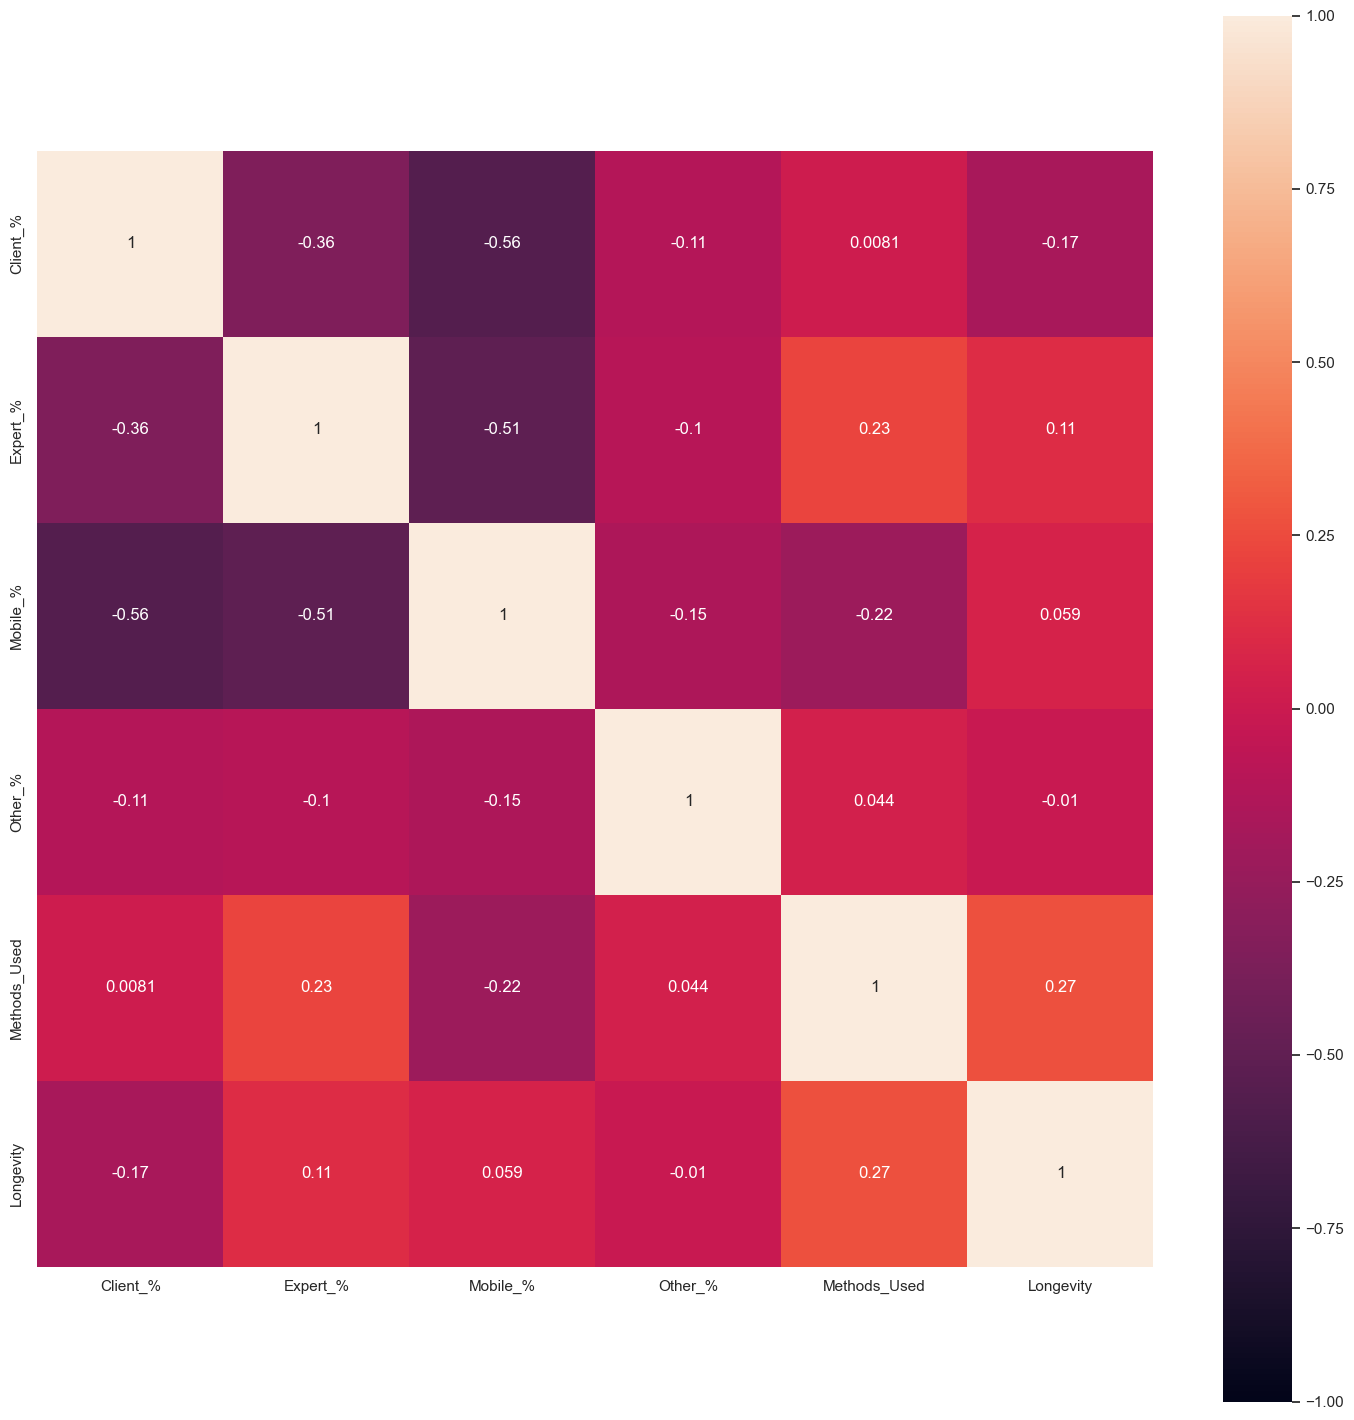

In [27]:
corr = 'pearson'

la_corr = login_activity.corr(method=corr)
tt_corr = trade_types[['Commodity_%', 'Crypto_%', 'Forex_%', 'Index_%', 'Metal_%', 'Oil_%', 'Types_Traded']].join(login_activity['Longevity']).corr(method=corr)
tv_corr = trade_volume_perc_1_level.join(login_activity['Longevity']).corr(method=corr)
tm_corr = trade_methods[['Client_%', 'Expert_%', 'Mobile_%', 'Other_%', 'Methods_Used']].join(login_activity['Longevity']).corr(method=corr)
aa_corr = account_activity.join(login_activity['Longevity']).corr(method=corr)
tp_corr = trading_periods.join(login_activity['Longevity']).corr(method=corr)

tm_f30_corr = trade_methods_f30.join(login_activity['Longevity']).corr(method=corr)

sns.set_theme(rc={'figure.figsize':(18,18)})

sns.heatmap(tm_f30_corr, annot=True, square=True, vmin=-1, vmax=1)

# WIP

2023 accounts that are missing reports and/or trades. We can ignore almost all of them since they don't have associated trade data. The exception is 808213, which has trades made but no account records.

In [28]:
null_reports = login_2023[login_2023.join(account_change.groupby('login').count())['balance'].isnull()].reset_index()['login']
null_reports

0       524987
1       524988
2       524989
3       524990
4       808213
        ...   
73     7065701
74     7067709
75     7070457
76    88944958
77    88945393
Name: login, Length: 78, dtype: int64

In [29]:
#Trades of null accounts
login_trades[login_trades.index.isin(null_reports)].groupby('login').count()['ticket']

login
808213    265
Name: ticket, dtype: int64

In [30]:
#Reports of null accounts
login_report[login_report.index.isin(null_reports)].groupby('login').count()['record_time']

Series([], Name: record_time, dtype: int64)

Country remapping check

In [31]:
#Use to check list of countries
login_2023.rename(columns={'Reg_Datetime' : 'Count'}).groupby('country').count()['Count'].to_csv('countries.csv')

Region mapping (totally incorrect atm)

In [32]:
login_2023_regions = login_2023.drop(columns=['account_currency', 'Reg_Datetime'])
#Mapping dictionary for regions
region_mapping = {
    'East Asia and Pacific': ['American Samoa', 'Australia', 'Brunei Darussalam', 'Cambodia', 'China', 'Fiji', 'French Polynesia', 'Guam', 'Hong Kong SAR, China', 'Indonesia', 'Japan', 'Kiribati', 'Korea, Dem. People\'s Rep.', 'Korea, Rep.', 'Lao PDR', 'Macao SAR, China', 'Malaysia', 'Marshall Islands', 'Micronesia, Fed. Sts.', 'Mongolia', 'Myanmar', 'Nauru', 'New Caledonia', 'New Zealand', 'Northern Mariana Islands', 'Palau', 'Papua New Guinea', 'Philippines', 'Samoa', 'Singapore', 'Solomon Islands', 'Taiwan, China', 'Thailand', 'Timor-Leste', 'Tonga', 'Tuvalu', 'Vanuatu', 'Vietnam'],
    'Europe and Central Asia': ['Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Faroe Islands', 'Finland', 'France', 'Georgia', 'Germany', 'Gibraltar', 'Greece', 'Greenland', 'Hungary', 'Iceland', 'Ireland', 'Isle of Man', 'Italy', 'Kazakhstan', 'Kosovo', 'Kyrgyz Republic', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russian Federation', 'San Marino', 'Serbia', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Tajikistan', 'Turkey', 'Turkmenistan', 'Ukraine', 'United Kingdom', 'Uzbekistan'],
    'Latin America & the Caribbean': ['Antigua and Barbuda', 'Argentina', 'Aruba', 'Bahamas, The', 'Barbados', 'Belize', 'Bermuda', 'Bolivia', 'Brazil', 'British Virgin Islands', 'Cayman Islands', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Curacao', 'Dominica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Grenada', 'Guatemala', 'Guyana', 'Haiti', 'Honduras', 'Jamaica', 'Martinique', 'Mexico', 'Montserrat', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Puerto Rico', 'Sint Maarten (Dutch part)', 'St. Kitts and Nevis', 'St. Lucia', 'St. Martin (French part)', 'St. Vincent and the Grenadines', 'Suriname', 'Trinidad and Tobago', 'Turks and Caicos Islands', 'Uruguay', 'Venezuela, RB', 'Virgin Islands (U.S.)'],
    'Middle East and North Africa': ['Algeria', 'Bahrain', 'Djibouti', 'Egypt, Arab Rep.', 'Iran, Islamic Rep.', 'Iraq', 'Israel', 'Jordan', 'Kuwait', 'Lebanon', 'Libya', 'Malta', 'Morocco', 'Oman', 'Qatar', 'Saudi Arabia', 'Syrian Arab Republic', 'Tunisia', 'United Arab Emirates', 'West Bank and Gaza', 'Yemen, Rep.'],
    'North America': ['Bermuda', 'Canada', 'United States'],
    'South Asia': ['Afghanistan', 'Bangladesh', 'Bhutan', 'India', 'Maldives', 'Nepal', 'Pakistan', 'Sri Lanka'],
    'Sub-Saharan Africa': ['Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Côte d'Ivoire", 'Djibouti', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia, The', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Mayotte', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Réunion', 'Saint Helena', 'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Uganda', 'Zambia', 'Zimbabwe', 'Aland Islands', 'Antarctica', 'Bahamas', 'Bonaire, Sint Eustatius and Saba', 'British Indian Ocean Territory', 'Brunei', 'Cape Verde', 'Cote D\'ivoire', 'Egypt', 'French Guiana', 'Gambia', 'Guadeloupe', 'Guernsey', 'Hong Kong', 'Iran', 'Jersey', 'Kyrgyzstan', 'Laos', 'Macedonia', 'Palestine', 'Pitcairn', 'Republic of the Congo', 'Reunion', 'Russia', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Martin', 'Saint Vincent and The Grenadine', 'Slovakia', 'South Georgia and The South Sandwich Islands', 'South Korea', 'Syria', 'Taiwan', 'Venezuela', 'Wallis and Futuna']
}
#Map regions to new column
login_2023_regions['Region'] = login_2023_regions['country'].map({country: region for region, countries in region_mapping.items() for country in countries})
#Mapping dictionary for economic development categories
economic_development_mapping = {
    'Developed': ['Australia', 'Austria', 'Belgium', 'Canada', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Hong Kong', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'South Korea', 'Luxembourg', 'Netherlands', 'New Zealand', 'Norway', 'Portugal', 'Singapore', 'Spain', 'Sweden', 'Switzerland', 'Taiwan', 'United Kingdom', 'United States'],
    'Emerging': ['Brazil', 'Chile', 'China', 'Colombia', 'Czech Republic', 'Hungary', 'India', 'Indonesia', 'Malaysia', 'Mexico', 'Philippines', 'Poland', 'Qatar', 'Russia', 'Saudi Arabia', 'South Africa', 'Thailand', 'Turkey', 'United Arab Emirates'],
    'Frontier': ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'British Indian Ocean Territory', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chad', 'Channel Islands', 'Chile', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Faroe Islands', 'Fiji', 'French Guiana', 'French Polynesia', 'Gabon', 'Gambia, The', 'Georgia', 'Gibraltar', 'Greenland', 'Grenada', 'Guadeloupe', 'Guam', 'Guatemala', 'Guernsey', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Iran', 'Isle of Man', 'Jersey', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Macedonia', 'Madagascar', 'Malawi', 'Maldives', 'Mali', 'Malta', 'Martinique', 'Mauritania', 'Mauritius', 'Mayotte', 'Moldova', 'Monaco', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nauru', 'Nepal', 'New Caledonia', 'Nicaragua', 'Niger', 'Nigeria', 'North Macedonia', 'Oman', 'Pakistan', 'Palau', 'Palestine', 'Papua New Guinea', 'Pitcairn', 'Poland', 'Puerto Rico', 'Qatar', 'Republic of the Congo', 'Reunion', 'Romania', 'Réunion', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Martin', 'Saint Vincent and The Grenadine', 'Samoa', 'Sao Tome and Principe', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Solomon Islands', 'South Georgia and The South Sandwich Islands', 'Suriname', 'Syria', 'Tajikistan', 'Tanzania', 'Timor-Leste', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Tuvalu', 'Uganda', 'Ukraine', 'United Arab Emirates', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam', 'Wallis and Futuna', 'Yemen', 'Zambia', 'Zimbabwe', 'Aland Islands', 'Antarctica', 'Bahamas', 'Bonaire, Sint Eustatius and Saba', 'Cape Verde', 'Costa Rica', "Cote D'ivoire", 'Gambia', 'Ghana', 'Honduras', 'Jamaica', 'Panama', 'Paraguay', 'Peru', 'Rwanda', 'Slovakia', 'Slovenia', 'Sri Lanka', 'Turks and Caicos Islands', 'Virgin Islands (U.S.)']
}
#Map development to new column
login_2023_regions['Economic_Development'] = login_2023_regions['country'].map({country: development for development, countries in economic_development_mapping.items() for country in countries})

login_2023_regions
#Nan check below
#login_2023_regions[login_2023_regions['Economic_Development'].isna()].rename(columns={'Reg_Datetime' : 'Count'}).groupby('country').count()['Count']#.to_csv('nan_countries.csv')

,country,Region,Economic_Development
login,,,
524972,France,Europe and Central Asia,Developed
524974,Switzerland,Europe and Central Asia,Developed
524976,Austria,Europe and Central Asia,Developed
524978,Austria,Europe and Central Asia,Developed
524979,France,Europe and Central Asia,Developed
...,...,...,...
1000055123,Canada,North America,Frontier
1000055441,South Korea,Sub-Saharan Africa,Developed
1000055515,Netherlands,Europe and Central Asia,Developed
